# Programming assignment 2: Random forests

Group members:

- Isac Snecker

- Isak Söderlind

- Simon Westlin Green


## Task 1: Working with a dataset with categorical features


### Step 1:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer

PREDICTION_COLUMN = "target"

train = pd.read_csv("adult_train.csv")
test = pd.read_csv("adult_test.csv")

X_train = train.drop(columns=[PREDICTION_COLUMN])
y_train = train[PREDICTION_COLUMN]

X_test = test.drop(columns=[PREDICTION_COLUMN])
y_test = test[PREDICTION_COLUMN]


### Step 2: Encoding the features as numbers


In [2]:
X_train_dict = X_train.to_dict(orient="records")
y_train_dict = y_train.to_dict()

X_test_dict = X_test.to_dict(orient="records")
y_test_dict = y_test.to_dict()


dv = DictVectorizer()
X_train_encoded = dv.fit_transform(X_train_dict)
X_test_encoded = dv.transform(X_test_dict)


### Step 2.5: Testing classifiers


In [3]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

classifiers = (
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    Perceptron(),
    LinearSVC(),
    DecisionTreeClassifier(),
)
for clf in classifiers:
    clf.fit(X_train_encoded, y_train)
    accuracy = clf.score(X_test_encoded, y_test)
    print(f"{clf.__class__.__name__}: {accuracy:.4f}")


GradientBoostingClassifier: 0.8711
RandomForestClassifier: 0.8448
Perceptron: 0.7988
LinearSVC: 0.8531
DecisionTreeClassifier: 0.8184


### Step 3: Combining the steps


In [4]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingClassifier

pipeline = make_pipeline(
    FunctionTransformer(lambda df: df.to_dict(orient="records"), validate=False),
    DictVectorizer(),
    GradientBoostingClassifier(),
)

pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)
print(f"{pipeline.__class__.__name__}: {accuracy:.4f}")


Pipeline: 0.8712


## Task 2: Decision trees and random forests


### Step 1: Underfitting and overfitting in decision tree classifiers


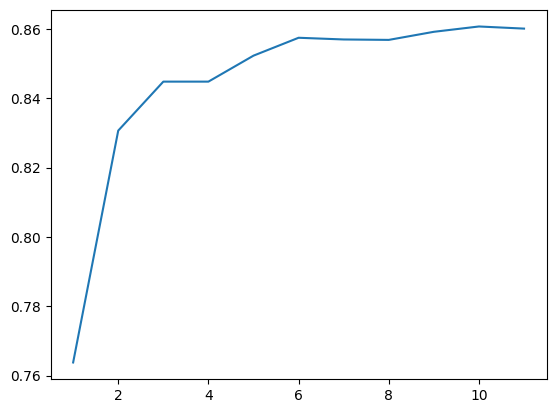

In [5]:
from sklearn.tree import DecisionTreeClassifier

accuracies = {}

for max_depth in range(1, 12):
    dt_clf = DecisionTreeClassifier(max_depth=max_depth)
    dt_clf.fit(X_train_encoded, y_train)
    dt_accuracy = dt_clf.score(X_test_encoded, y_test)
    accuracies[max_depth] = dt_accuracy
plt.plot(list(accuracies.keys()), list(accuracies.values()))


### Step 2: Underfitting and overfitting in random forest classifiers


Trained RandomForest with 1 trees in 0.89 seconds.
Trained RandomForest with 2 trees in 1.16 seconds.
Trained RandomForest with 4 trees in 1.13 seconds.
Trained RandomForest with 8 trees in 1.23 seconds.
Trained RandomForest with 32 trees in 2.42 seconds.
Trained RandomForest with 128 trees in 6.80 seconds.
Trained RandomForest with 512 trees in 25.46 seconds.


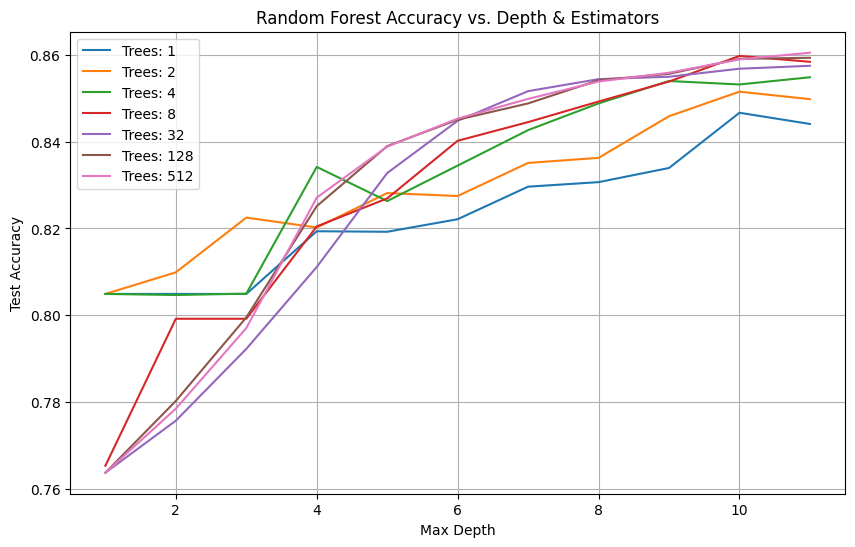

In [6]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import time

n_estimators_list = [1, 2, 4, 8, 32, 128, 512]
depths = range(1, 12)

plt.figure(figsize=(10, 6))

for n in n_estimators_list:
    start = time.perf_counter()
    accuracies = []
    for d in depths:
        rf_clf = RandomForestClassifier(
            max_depth=d, n_estimators=n, n_jobs=-1, random_state=42
        )
        rf_clf.fit(X_train_encoded, y_train)
        accuracies.append(rf_clf.score(X_test_encoded, y_test))
    total = time.perf_counter() - start
    print(f"Trained RandomForest with {n} trees in {total:.2f} seconds.")

    plt.plot(depths, accuracies, label=f"Trees: {n}")

plt.xlabel("Max Depth")
plt.ylabel("Test Accuracy")
plt.title("Random Forest Accuracy vs. Depth & Estimators")
plt.legend()
plt.grid(True)
plt.show()


- What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?

The main difference seems to be that the random forest performs better at lower depths compared to the decision tree.

This is because even with a single tree the random forest introduces randomness when selecting features.

This randomness helps reduce overfitting, but leads to decreased performance at higher depths where the decision tree can fully utilize the training data.

- What happens with the curve for random forests as the ensemble size grows?

For lower ensambles the curve starts at a higher value, closer to 0.8, but increases slower towards a lower maximum.

As the ensamble size grows the curve starts at a lower value and reaches a higher maximum of about 0.86.

It also grows more evenly with depth.

- What happens with the best observed test set accuracy as the ensemble size grows?

The best observed test set accuracy increases as the ensemble size grows.

The highest accuracy observed with 1 tree is around 0.845, with 512 trees around 0.86.

- What happens with the training time as the ensemble size grows?

The training time increases linearly with the size of the ensemble as the ensemble size grows.


In [7]:
dv = pipeline.steps[1][1]
gbc = pipeline.steps[2][1]

feature_names = dv.feature_names_
importances = gbc.feature_importances_

# Pairs feature names with their importances and sort them in descending order
sorted_importances = sorted(
    zip(feature_names, importances), key=lambda x: x[1], reverse=True
)
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")


marital-status=Married-civ-spouse: 0.3824
capital-gain: 0.2015
education-num: 0.1987
age: 0.0606
capital-loss: 0.0588
hours-per-week: 0.0361
occupation=Exec-managerial: 0.0179
occupation=Prof-specialty: 0.0089
relationship=Wife: 0.0047
occupation=Farming-fishing: 0.0046
occupation=Other-service: 0.0041
workclass=Self-emp-not-inc: 0.0032
occupation=Tech-support: 0.0024
workclass=Local-gov: 0.0016
workclass=Federal-gov: 0.0015
sex=Male: 0.0014
occupation=Sales: 0.0012
occupation=Protective-serv: 0.0010
workclass=Self-emp-inc: 0.0008
marital-status=Married-AF-spouse: 0.0008
relationship=Own-child: 0.0007
race=White: 0.0006
occupation=Handlers-cleaners: 0.0006
sex=Female: 0.0005
native-country=United-States: 0.0005
marital-status=Never-married: 0.0004
occupation=Adm-clerical: 0.0004
workclass=Private: 0.0003
education=Masters: 0.0003
relationship=Husband: 0.0003
relationship=Not-in-family: 0.0003
education=Bachelors: 0.0003
occupation=Machine-op-inspct: 0.0002
native-country=Philippines: 0

- Reasoning about the top importances

Our top three scores are marital status (married-civ-spouse), capital gain and education. It makes sense that marriage is a factor since you are more likely to be

older and also, most people would probably not get married if they lack economic resources. Capital gain makes sense since it is essentially "spending money to make money"

meaning that you need to have money to get a capital which you may gain from. Education makes sense since jobs that require a higher education typically have higher salaries.

- Alternative way of calculating feature importance#

First, train the model as usual and calculate the accuracy on the test set. Then for each feature, randomly shuffle its values in the test set and calculate the accuracy again.

If the accuracy drops significantly, it probably means that the feature is important for the model's predictions.
